In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
from matplotlib.animation import FuncAnimation


class SineActivation(nn.Module):
    def __init__(self, omega_0=30.0):
        """
        Initializes the SineActivation module.

        Args:
            omega_0 (float): Frequency scaling factor. A higher value increases the frequency of oscillations.
        """
        super(SineActivation, self).__init__()
        self.omega_0 = omega_0

    def forward(self, x):
        """
        Applies the sine activation function to the input.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output after applying sin(omega_0 * x).
        """
        return torch.sin(self.omega_0 * x)
def init_sine_weights(model, omega_0=10.0):
    with torch.no_grad():
        # Input layer
        model.input_layer.weight.uniform_(-1.0 / model.input_layer.in_features,
                                          1.0 / model.input_layer.in_features)
        model.input_layer.bias.fill_(0.0)

        # Hidden layers
        for layer in model.hidden_layers:
            layer.weight.uniform_(-np.sqrt(6 / layer.in_features) / omega_0,
                                  np.sqrt(6 / layer.in_features) / omega_0)
            layer.bias.fill_(0.0)

        # Output layer
        model.output_layer.weight.uniform_(-np.sqrt(6 / model.output_layer.in_features) / omega_0,
                                           np.sqrt(6 / model.output_layer.in_features) / omega_0)
        model.output_layer.bias.fill_(0.0)

'''
class AdaptiveBasisLayer(nn.Module):
    """
    A toy example of an 'Abu-PINN' style layer that adaptively learns
    multiple sine basis functions, each with its own frequency and amplitude.
    """
    def __init__(self, in_features, n_bases=5):
        """
        Args:
            in_features (int): Dimensionality of input (e.g., 1 for t in 1D).
            n_bases (int): Number of sine basis functions to learn.
        """
        super(AdaptiveBasisLayer, self).__init__()
        self.n_bases = n_bases

        # Frequencies and amplitudes as learnable parameters
        self.frequencies = nn.Parameter(torch.randn(n_bases, in_features))
        self.amplitudes  = nn.Parameter(torch.randn(n_bases, in_features))

    def forward(self, x):
        """
        x: (batch_size, in_features)
        Returns: (batch_size, 1) after summing over the basis functions.
        """
        # Expand x for broadcasting: shape => (batch_size, 1, in_features)
        x_expanded = x.unsqueeze(1)

        # Dot product with frequencies & amplitudes:
        # freq_dot_x, amp_dot_x => (batch_size, n_bases)
        freq_dot_x = torch.einsum('bni,ni->bn', x_expanded, self.frequencies)
        amp_dot_x  = torch.einsum('bni,ni->bn', x_expanded, self.amplitudes)

        # Sine transform: sin( freq_dot_x ), then scale by amplitude
        sine_output   = torch.sin(freq_dot_x)         # (batch_size, n_bases)
        out_per_basis = amp_dot_x * sine_output       # (batch_size, n_bases)

        # Sum across all bases => final shape: (batch_size, 1)
        out = out_per_basis.sum(dim=1, keepdim=True)
        return out
'''

'\nclass AdaptiveBasisLayer(nn.Module):\n    """\n    A toy example of an \'Abu-PINN\' style layer that adaptively learns\n    multiple sine basis functions, each with its own frequency and amplitude.\n    """\n    def __init__(self, in_features, n_bases=5):\n        """\n        Args:\n            in_features (int): Dimensionality of input (e.g., 1 for t in 1D).\n            n_bases (int): Number of sine basis functions to learn.\n        """\n        super(AdaptiveBasisLayer, self).__init__()\n        self.n_bases = n_bases\n\n        # Frequencies and amplitudes as learnable parameters\n        self.frequencies = nn.Parameter(torch.randn(n_bases, in_features))\n        self.amplitudes  = nn.Parameter(torch.randn(n_bases, in_features))\n\n    def forward(self, x):\n        """\n        x: (batch_size, in_features)\n        Returns: (batch_size, 1) after summing over the basis functions.\n        """\n        # Expand x for broadcasting: shape => (batch_size, 1, in_features)\n        

In [ ]:
def exact_solution(t):
    return (1 + (t/6 * np.cos(30)) - ((np.sin(6*t))/36))

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, omega_0=5.0):
        super(FCN, self).__init__()
        self.input_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.activation = SineActivation(omega_0)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)]
        )
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        return x

        '''

class AbuPINN(nn.Module):
    def __init__(self, n_bases=3, N_HIDDEN=32, N_LAYERS=4,
                 in_features=1, out_features=1):
        """
        A network that uses the adaptive basis layer as input, then an MLP.
        """
        super(AbuPINN, self).__init__()

        # 1) Adaptive basis layer
        self.adaptive_basis = AdaptiveBasisLayer(in_features, n_bases)

        # 2) Build an MLP on top of the basis layer's output
        layers = []
        current_in = 1  # Because the basis layer outputs shape (batch_size, 1)
        for _ in range(N_LAYERS):
            layers.append(nn.Linear(current_in, N_HIDDEN))
            layers.append(nn.ReLU())  # or ReLU, etc.
            current_in = N_HIDDEN

        # Final output layer
        layers.append(nn.Linear(N_HIDDEN, out_features))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # Pass input through adaptive basis first
        basis_out = self.adaptive_basis(x)
        # Then through the MLP
        return self.mlp(basis_out)
        '''


Adam iteration 0, Loss: 3.5750e+00
Adam iteration 1000, Loss: 4.1634e-01
Adam iteration 2000, Loss: 1.4508e-01
Adam iteration 3000, Loss: 3.5310e-02
Adam iteration 4000, Loss: 1.3457e-02
LBFGS step 0, Loss: 5.9300e-03
LBFGS step 5, Loss: 6.9605e-06
LBFGS step 10, Loss: 6.9579e-06
LBFGS step 15, Loss: 6.9579e-06


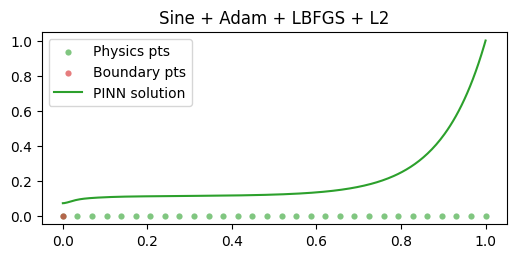

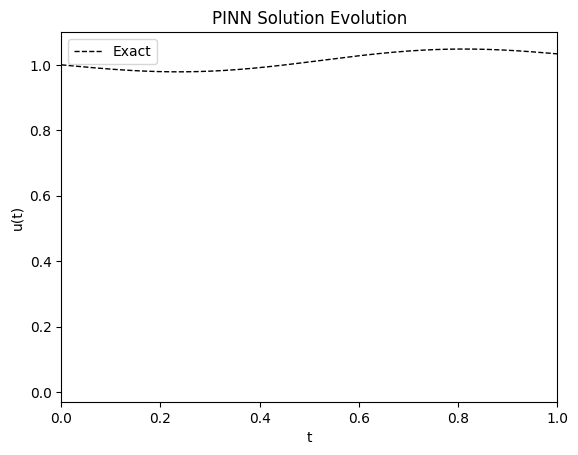

'\ntorch.manual_seed(123)\n\n# Instantiate the AbuPINN for the first PDE\npinn = AbuPINN(n_bases=3, N_HIDDEN=32, N_LAYERS=4, in_features=1, out_features=1)\n\n# Boundary points\nt_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)\nt_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)\n\n# Physics (domain) points\nt_physics = torch.linspace(0.,1,30).view(-1,1).requires_grad_(True)\n\n# Test points for plotting\nt_test = torch.linspace(0.,1,300).view(-1,1)\nu_exact = exact_solution(t_test)\n\n# Rescale factor to reduce large PDE coefficients\nrescale_factor = 1\n\n# Optimizer\noptimiser = torch.optim.Adam(pinn.parameters(), lr=1e-6)\n\n# Training loop\nnum_iterations = 20001\nfor i in range(num_iterations):\n    optimiser.zero_grad()\n\n    # Weighted loss hyperparams\n    lambda1, lambda2 = 1, 1\n\n    # Boundary loss\n    u0 = pinn(t_boundary0)\n    dudt0 = torch.autograd.grad(u0, t_boundary0, torch.ones_like(u0), create_graph=True)[0]\n    loss_bc0 = (dudt0.squeeze

In [ ]:


#HyperParameters ->
# 1. Network neurons + number of layers
# 2. lambda1, lambda2 -> weights of losses
# 3. lr in optimizer

torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,10, omega_0=5.0)
init_sine_weights(pinn, omega_0=10.0)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0.,1,30).view(-1,1).requires_grad_(True)

# train the PINN
#d, w0 = 2, 20
#mu, k = 2*d, w0**2
t_test = torch.linspace(0.,1,300).view(-1,1)
u_exact = exact_solution(t_test)

def compute_loss_for_pinn():
    """
    Computes boundary + physics losses for the first network (pinn).
    Returns a single scalar loss tensor.
    """
    # boundary loss
    u1 = pinn(t_boundary0)
    dudt = torch.autograd.grad(u1, t_boundary0, torch.ones_like(u1), create_graph=True)[0]
    loss_bc0 = (torch.squeeze(dudt) - 0)**2

    u2 = pinn(t_boundary1)
    loss_bc1 = (torch.squeeze(u2) - 1)**2

    # physics loss
    u = pinn(t_physics)
    dudt_ = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2_ = torch.autograd.grad(dudt_, t_physics, torch.ones_like(dudt_), create_graph=True)[0]

    rescale_factor = 0.25
    residual = (
        rescale_factor * t_physics * d2udt2_ +
        rescale_factor * dudt_ -
        rescale_factor *(t_physics * (u/.01)) +
        rescale_factor * (t_physics * (1/0.09))
    )
    loss_phys = torch.mean(residual**2)

    loss = loss_bc0 + loss_bc1 + loss_phys
    l2_lambda = 1e-5  # <--- Tweak this as needed
    l2_reg = 0.0
    for param in pinn.parameters():
        l2_reg += torch.sum(param**2)
    #loss = loss + l2_lambda * l2_reg

    return loss
pinn1_solutions = []
adam_optim = torch.optim.Adam(pinn.parameters(), lr=1e-5,weight_decay=1e-4)
adam_steps = 5000

for i in range(adam_steps):
    adam_optim.zero_grad()
    loss = compute_loss_for_pinn()
    loss.backward()
    total_grad_norm = 0.0
    for p in pinn.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_grad_norm += param_norm.item()**2
    total_grad_norm = total_grad_norm**0.5

    if i % 500 == 0:
        with torch.no_grad():
            u_plot = pinn(t_test).detach().cpu().numpy().flatten()
        pinn1_solutions.append((i, u_plot))

    if i % 1000 == 0:
        print(f"Adam iteration {i}, Loss: {loss.item():.4e} ")
    nn_utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)

    adam_optim.step()

# PHASE 2: LBFGS
lbfgs_optim = torch.optim.LBFGS(
    pinn.parameters(),
    lr=1e-1,        # LBFGS often uses a higher LR
    max_iter=500,   # how many internal steps LBFGS can do per .step() call
    history_size=100
)

def lbfgs_closure():
    lbfgs_optim.zero_grad()
    loss_lbfgs = compute_loss_for_pinn()
    loss_lbfgs.backward()
    return loss_lbfgs

lbfgs_steps = 20
for j in range(lbfgs_steps):
    loss_val = lbfgs_optim.step(lbfgs_closure)
    with torch.no_grad():
        u_plot = pinn(t_test).detach().cpu().numpy().flatten()
    iteration_label = adam_steps + (j+1)*100  # or something symbolic
    pinn1_solutions.append((iteration_label, u_plot))
    if j % 5 == 0:
        print(f"LBFGS step {j}, Loss: {loss_val.item():.4e}")

# After two-phase training, let's plot the final result
u_plot = pinn(t_test).detach()
plt.figure(figsize=(6,2.5))
plt.scatter(t_physics.detach()[:,0], torch.zeros_like(t_physics)[:,0],
            s=20, lw=0, color="tab:green", alpha=0.6, label="Physics pts")
plt.scatter(t_boundary0.detach()[:,0], torch.zeros_like(t_boundary0)[:,0],
            s=20, lw=0, color="tab:red", alpha=0.6, label="Boundary pts")
#plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.plot(t_test[:,0], u_plot[:,0], label="PINN solution", color="tab:green")
plt.title("Sine + Adam + LBFGS + L2")
plt.legend()
plt.show()
fig, ax = plt.subplots()
t_test_np = t_test.detach().cpu().numpy().flatten()

# We'll create an empty line that we'll update in each frame
line, = ax.plot([], [], 'g-', lw=2)
ax.plot(t_test_np, u_exact[:,0], 'k--', lw=1, label="Exact")  # optional exact overlay
ax.set_xlim([t_test_np[0], t_test_np[-1]])
ax.set_ylim([u_plot.min()-0.1, u_plot.max()+0.1])  # adjust as needed
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
ax.set_title("PINN Solution Evolution")
ax.legend()

iteration_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init_anim():
    line.set_data([], [])
    iteration_text.set_text('')
    return line, iteration_text

def update_anim(frame):
    iter_num, y_data = pinn1_solutions[frame]
    line.set_data(t_test_np, y_data)
    iteration_text.set_text(f"Iteration: {iter_num}")
    return line, iteration_text

anim = FuncAnimation(fig, update_anim, frames=len(pinn1_solutions),
                     init_func=init_anim, blit=True, interval=6)

# Show the animation
plt.show()
"""
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-6)


for i in range(25001):
    optimiser.zero_grad()

      # compute each term of the PINN loss function above
      # using the following hyperparameters:
    lambda1, lambda2 = 1, 1#review

      # compute boundary loss
      # TODO: write code here
    u1 = pinn(t_boundary0)
    dudt = torch.autograd.grad(u1, t_boundary0, torch.ones_like(u1), create_graph=True)[0]
    loss1 = (torch.squeeze(dudt) - 0)**2  # derivative at t=0 = 0

    u2 = pinn(t_boundary1)
    loss2 = (torch.squeeze(u2) - 1)**2   # function value at t=1 = 1

    # compute physics loss with rescaling
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    # Original PDE: (t*d2udt2) + dudt - (t*(u/0.1)) + (t*(1/0.9)) = 0
    # => (t*d2udt2) + dudt - 10*t*u + 1.111*t = 0
    # Multiply entire PDE by rescale_factor = 0.1 to reduce large coefficients
    residual = (
        rescale_factor * t_physics * d2udt2 +
        rescale_factor * dudt -
        rescale_factor * (t_physics * (u/0.01)) +
        rescale_factor * (t_physics * (1/0.09))
    )
    loss3 = torch.mean(residual**2)
  #loss3 = torch.mean(((t_physics*d2udt2) + (dudt) - (t_physics * (u / 0.01)) + (t_physics * (1/0.09)))**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()



    optimiser.step()

    # plot the result as training progresses
    if i % 1000 == 0:
        u_plot = pinn(t_test).detach()
        print(f"Iteration {i}, Loss: {loss.item():.4e}")
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0,
                    color="tab:green", alpha=0.6, label="Physics pts")
        plt.scatter(t_boundary0.detach()[:,0],
                    torch.zeros_like(t_boundary0)[:,0], s=20, lw=0,
                    color="tab:red", alpha=0.6, label="Boundary pts")
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution",
                 color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u_plot[:,0], label="PINN solution",
                 color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
"""
'''
torch.manual_seed(123)

# Instantiate the AbuPINN for the first PDE
pinn = AbuPINN(n_bases=3, N_HIDDEN=32, N_LAYERS=4, in_features=1, out_features=1)

# Boundary points
t_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)

# Physics (domain) points
t_physics = torch.linspace(0.,1,30).view(-1,1).requires_grad_(True)

# Test points for plotting
t_test = torch.linspace(0.,1,300).view(-1,1)
u_exact = exact_solution(t_test)

# Rescale factor to reduce large PDE coefficients
rescale_factor = 1

# Optimizer
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-6)

# Training loop
num_iterations = 20001
for i in range(num_iterations):
    optimiser.zero_grad()

    # Weighted loss hyperparams
    lambda1, lambda2 = 1, 1

    # Boundary loss
    u0 = pinn(t_boundary0)
    dudt0 = torch.autograd.grad(u0, t_boundary0, torch.ones_like(u0), create_graph=True)[0]
    loss_bc0 = (dudt0.squeeze() - 0)**2  # e.g., derivative=0 at t=0

    u1 = pinn(t_boundary1)
    loss_bc1 = (u1.squeeze() - 1)**2     # e.g., u(1)=1

    # Physics loss with PDE rescaling
    u_physics = pinn(t_physics)
    dudt = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    # Example PDE: t*d2u/dt^2 + du/dt - t*(u/0.1) + t*(1/0.9) = 0
    # => large coefficients => multiply entire PDE by rescale_factor
    # Original PDE has terms like 10*u, so we reduce them:
    residual = (
        rescale_factor * t_physics * d2udt2
        + rescale_factor * dudt
        - (t_physics * (u_physics/0.01))
        + rescale_factor * (t_physics * (1/0.09))
    )
    loss_phys = torch.mean(residual**2)

    # Combine losses
    loss = loss_bc0 + lambda1*loss_bc1 + lambda2*loss_phys
    loss.backward()

    # Gradient clipping
    #nn_utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)

    optimiser.step()

    # Periodic logging & plotting
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.4e}")
        u_plot = pinn(t_test).detach()

        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach(), torch.zeros_like(t_physics), color="green",
                    alpha=0.6, label="Physics pts")
        plt.scatter(t_boundary0.detach(), torch.zeros_like(t_boundary0), color="red",
                    alpha=0.6, label="Boundary pts")
        if u_exact is not None:
            plt.plot(t_test, u_exact, color="gray", alpha=0.6, label="Exact solution")
        plt.plot(t_test, u_plot, color="green", label="PINN solution")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
'''




In [ ]:
pinn2 = FCN(1,1,32,3)
# No special initialization here, but you can do so if you like

t2_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)

# We'll keep t_physics and t_test the same as before
optimiser = None  # We'll define two-phase approach inside the ODE function

def compute_loss_for_pinn2(lamb=0.1, psys=1, lambf=0.3, k=1, ros=1, f=1):
    """
    Computes boundary + physics loss for 'pinn2' given PDE parameters.
    Returns a single scalar loss tensor.
    """
    # boundary losses
    y1 = pinn2(t2_boundary0)
    dydt_0 = torch.autograd.grad(y1, t2_boundary0, torch.ones_like(y1), create_graph=True)[0]
    loss21 = (torch.squeeze(dydt_0) - 0)**2

    y2 = pinn2(t2_boundary1)
    loss22 = (torch.squeeze(y2) - 0)**2

    # physics loss
    y = pinn2(t_physics)
    dydt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
    d2ydt2 = torch.autograd.grad(dydt, t_physics, torch.ones_like(dydt), create_graph=True)[0]

    # coupling with first network
    u = pinn(t_physics).detach()

    # PDE: t*d2y/dt^2 + dydt - t*(y/k) + t*ros + t*(u/(lamb*lamb)) = 0
    # No rescale factor here, but you can add one if needed
    '''residual2 = (
        t_physics * d2ydt2 +
        dydt -
        t_physics * (y/k) +
        t_physics * ros +
        t_physics * (u/(lamb*lamb))
    )'''
    residual2= (((t_physics*d2ydt2) + (dydt) - (t_physics * (y / 10)) + (t_physics * (1)) + (t_physics * (u/0.01)))**2)
    loss23 = torch.mean(residual2**2)

    loss2 = loss21 + loss22 + loss23
    return loss2

def ODE(lamb=0.1, psys=1, lambf=0.3, k=1, ros=1, f=1):
    """
    Trains pinn2 under different parameters using a two-phase approach:
    1) Adam
    2) LBFGS
    Then returns the solution at t_test.
    """

    # PHASE 1: Adam
    adam_optim_2 = torch.optim.Adam(pinn2.parameters(), lr=1e-3)
    adam_steps_2 = 3000
    for i in range(adam_steps_2):
        adam_optim_2.zero_grad()
        loss_2 = compute_loss_for_pinn2(lamb, psys, lambf, k, ros, f)
        loss_2.backward()
        # optional: gradient clipping for Adam
        nn_utils.clip_grad_norm_(pinn2.parameters(), max_norm=1.0)
        adam_optim_2.step()
    if i % 1000 == 0:
        print(f"Adam iteration {i}, Loss: {loss_2.item():.4e}")

    # PHASE 2: LBFGS
    lbfgs_optim_2 = torch.optim.LBFGS(pinn2.parameters(), lr=1e-1, max_iter=500, history_size=100)

    def lbfgs_closure_2():
        lbfgs_optim_2.zero_grad()
        loss_val_2 = compute_loss_for_pinn2(lamb, psys, lambf, k, ros, f)
        loss_val_2.backward()
        return loss_val_2

    lbfgs_steps_2 = 10
    for j in range(lbfgs_steps_2):
        loss_val = lbfgs_optim_2.step(lbfgs_closure_2)
    if j % 5 == 0:
        print(f"LBFGS step {j}, Loss: {loss_val.item():.4e}")

    # Return final solution for plotting
    return pinn2(t_test).detach()
'''
pinn2 = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t2_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)


# define training points over the entire domain, for the physics loss
# TODO: write code here

#-----------------------
#[IMPORTANT]: keeping physics input points same as the previous network and the Test input points the same as well.
#---------------

#t2_physics = torch.linspace(0.,1,30).view(-1,1).requires_grad_(True)

# train the PINN

t_test = torch.linspace(0.,1,300).view(-1,1)
u_exact = exact_solution(t_test)
optimiser = torch.optim.Adam(pinn2.parameters(),lr=1e-3)

def ODE (lamb=0.1, psys=1, lambf=0.3, k=1, ros=1, f=1):
  for i in range(20001):
      optimiser.zero_grad()

      # compute each term of the PINN loss function above
      # using the following hyperparameters:
      lambda21, lambda22 = 1, 1 #review

      # compute boundary loss
      # TODO: write code here
      y1 = pinn2(t2_boundary0)
      dydt = torch.autograd.grad(y1, t2_boundary0, torch.ones_like(y1), create_graph=True)[0]
      loss21 = (torch.squeeze(dydt) - 0)**2
      y2 = pinn2(t2_boundary1)
      loss22 = (torch.squeeze(y2) - 0)**2

      # compute physics loss
      # TODO: write code here
      y = pinn2(t_physics)
      dydt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
      d2ydt2 = torch.autograd.grad(dydt, t_physics, torch.ones_like(dydt), create_graph=True)[0]
      u = pinn(t_physics).detach()
      #loss23 = torch.mean(((t_physics*d2ydt2) + (dydt) - (t_physics * (y / 10)) + (t_physics * (1)) + (t_physics * (u/0.01)))**2)
      #loss23 = torch.mean(((t_physics*d2ydt2) + (dydt) - (t_physics * (y /k)) -(f *(y*y) / np.sqrt(k)) + (t_physics *ros) + (t_physics * (u/(lamb*lamb))))**2)
      loss23 = torch.mean(((t_physics*d2ydt2) + (dydt) - (t_physics * (y /k)) + (t_physics *ros) + (t_physics * (u/(lamb*lamb))))**2)

      # backpropagate joint loss, take optimiser step
      # TODO: write code here
      loss2 = loss21 + lambda21*loss22 + lambda22*loss23
      loss2.backward()
      optimiser.step()
      y = pinn2(t_test).detach()

  return y
  '''

'\npinn2 = FCN(1,1,32,3)\n\n# define boundary points, for the boundary loss\n# TODO: write code here\nt2_boundary0 = torch.tensor(0.).view(-1,1).requires_grad_(True)\nt2_boundary1 = torch.tensor(1.).view(-1,1).requires_grad_(True)\n\n\n# define training points over the entire domain, for the physics loss\n# TODO: write code here\n\n#-----------------------\n#[IMPORTANT]: keeping physics input points same as the previous network and the Test input points the same as well.\n#---------------\n\n#t2_physics = torch.linspace(0.,1,30).view(-1,1).requires_grad_(True)\n\n# train the PINN\n\nt_test = torch.linspace(0.,1,300).view(-1,1)\nu_exact = exact_solution(t_test)\noptimiser = torch.optim.Adam(pinn2.parameters(),lr=1e-3)\n\ndef ODE (lamb=0.1, psys=1, lambf=0.3, k=1, ros=1, f=1):\n  for i in range(20001):\n      optimiser.zero_grad()\n\n      # compute each term of the PINN loss function above\n      # using the following hyperparameters:\n      lambda21, lambda22 = 1, 1 #review\n\n      # 

In [ ]:
# plot the result as training progresses
#print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item)
ode1=ODE(k=0.1)

In [ ]:
ode2=ODE(k=10)

In [ ]:
ode3=ODE(k=1)

In [ ]:
ode4=ODE(k=100)

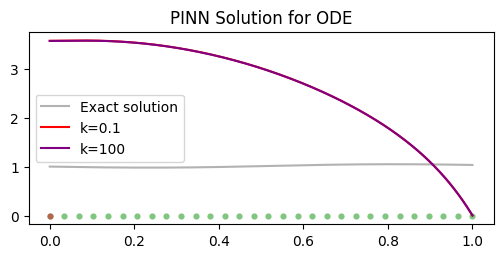

In [ ]:
plt.figure(figsize=(6,2.5))
plt.scatter(t_physics.detach()[:,0],torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
plt.scatter(t2_boundary0.detach()[:,0],torch.zeros_like(t2_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)

plt.plot(t_test[:,0], ode1[:,0], label="k=0.1", color="red")#plots PINN solution1
#plt.plot(t_test[:,0], ode3[:,0], label="k=1", color="blue")#plots PINN solution2
#plt.plot(t_test[:,0], ode2[:,0], label="k=10", color="green")#plots PINN solution3
plt.plot(t_test[:,0], ode4[:,0], label="k=100", color="purple")#plots PINN solution4


plt.title(f"PINN Solution for ODE")
plt.legend()
plt.show()
print()
print()

In [ ]:
ode5=ODE(ros=1, k=100)
ode6=ODE(ros=2, k=100)
ode7=ODE(ros=3, k=100)

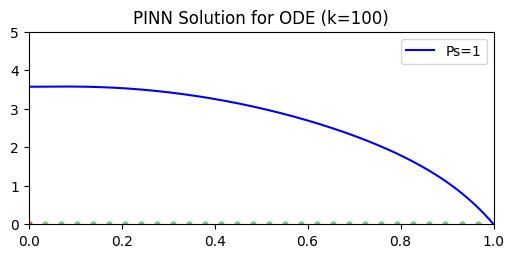

In [ ]:
plt.figure(figsize=(6,2.5))
plt.scatter(t_physics.detach()[:,0],torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
plt.scatter(t2_boundary0.detach()[:,0],torch.zeros_like(t2_boundary0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
          #plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)

plt.ylim(0,5)
plt.xlim(0,1)
plt.plot(t_test[:,0], ode5[:,0], label="Ps=1", color="blue" ) #plots PINN solution 1
#plt.plot(t_test[:,0], ode6[:,0], label="Ps=2", color="green") #plots PINN solution 2
#plt.plot(t_test[:,0], ode7[:,0], label="Ps=3", color="red") #plots PINN solution 3

plt.title(f"PINN Solution for ODE (k=100)")
plt.legend()
plt.show()
print()
print()